In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [310]:
# load the data from CSV file
x_train = pd.read_csv("input_train.csv")
x_train = np.array(x_train.iloc[:,0:9])
y_train = pd.read_csv("output_train.csv")
y_train = np.array(y_train)

x_test = pd.read_csv("input_test.csv")
x_test = np.array(x_test.iloc[:,0:9])
y_test = pd.read_csv("output_test.csv")
y_test = np.array(y_test)

In [311]:
x_train

array([[1.0000e+00, 5.0788e-01, 6.6583e-01, ..., 0.0000e+00, 9.8214e-01,
        9.6701e-01],
       [2.0000e+00, 5.3655e-01, 5.4175e-01, ..., 0.0000e+00, 9.8203e-01,
        9.6071e-01],
       [3.0000e+00, 5.4527e-01, 5.5425e-01, ..., 0.0000e+00, 9.8204e-01,
        9.5395e-01],
       ...,
       [8.3200e+02, 3.2798e-01, 6.0939e-01, ..., 5.0000e-01, 9.6860e-01,
        9.8665e-01],
       [8.3300e+02, 3.5233e-01, 4.7526e-01, ..., 5.0000e-01, 9.7254e-01,
        9.8569e-01],
       [8.3400e+02, 3.6856e-01, 4.9240e-01, ..., 5.0000e-01, 9.7611e-01,
        9.8326e-01]])

In [312]:
y_train.shape

(3226, 3)

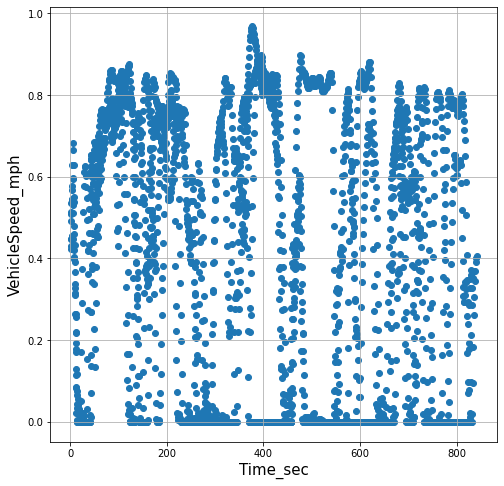

In [298]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x_train[0:,0],x_train[0:,1])
plt.xlabel('Time_sec', fontsize=15)
plt.ylabel('VehicleSpeed_mph', fontsize=15)
plt.grid()

# Random Forest

In [313]:
#prepare the model

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
#create an array which will hold samples split to be tested
samples_split = np.array([25, 50, 75, 100, 125, 150, 200, 250, 300, 500])
#create an empty array to hold Mean Abosulte error values
train_MAE = []
test_MAE = []
# For loop to go over different sample split scenarios
for i in range (0,10):
    regressor = RandomForestRegressor(n_estimators = 10, min_samples_split=samples_split[i],random_state = 2)
    regressor.fit(x_train, y_train)
    Predict = regressor.predict(x_train)
    Predict_test = regressor.predict(x_test)
    train_MAE.append(metrics.mean_absolute_error(y_train[:,0], Predict[:,0]))
    test_MAE.append(metrics.mean_absolute_error(y_test[:,0], Predict_test[:,0]))
    #print("Mean Absolute Error:", metrics.mean_absolute_error(y_train[:,0], Predict[:,0]))

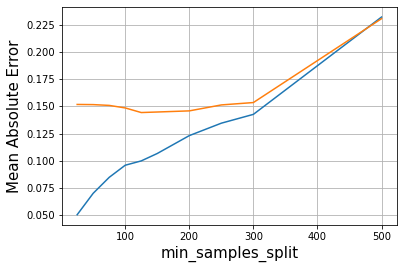

In [314]:
#Comapre the performance of training random forest model for training data set and test data set for predicting velocity
plt.figure(1)
plt.plot(samples_split, train_MAE)
plt.plot(samples_split, test_MAE)
plt.xlabel('min_samples_split', fontsize = 15)
plt.ylabel('Mean Absolute Error', fontsize = 15)
plt.grid()

In [315]:
# From above figure we can see that we get minimum test MAE score around 125.
finetuned_regressor = RandomForestRegressor( n_estimators = 10, min_samples_split=125,random_state = 2)
finetuned_regressor.fit(x_train, y_train)
finetuned_predict= finetuned_regressor.predict(x_train)
finetuned_predict_test = finetuned_regressor.predict(x_test)
print("Mean Absolute Error for training data set:", metrics.mean_absolute_error(y_train[:,0], finetuned_predict[:,0]))
print("Mean Absolute Error for test data set:", metrics.mean_absolute_error(y_test[:,0], finetuned_predict_test[:,0]))

Mean Absolute Error for training data set: 0.09981087986540094
Mean Absolute Error for test data set: 0.1443185990833361


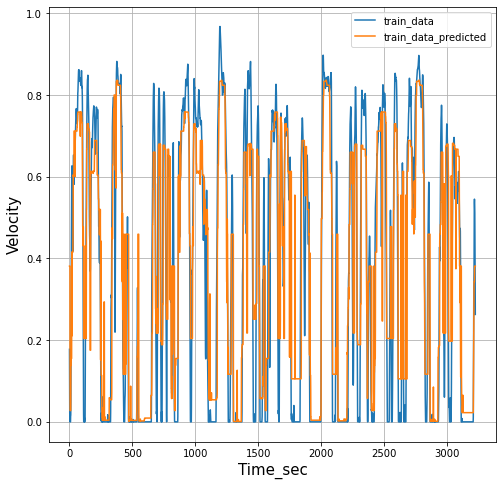

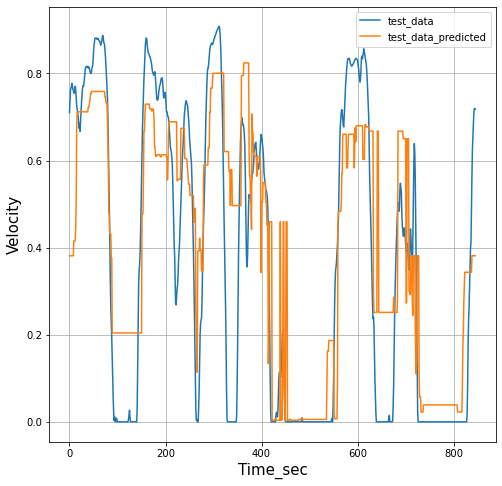

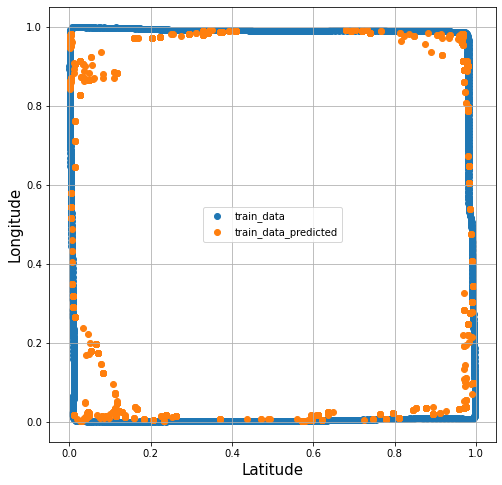

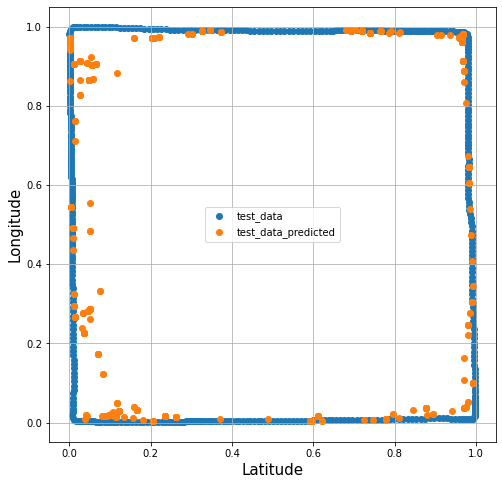

In [316]:
plt.figure(2, figsize=(8,8))
plt.plot(y_train[:,0], label="train_data")
plt.plot(finetuned_predict[:,0], label="train_data_predicted" )
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(3, figsize=(8,8))
plt.plot(y_test[:,0], label="test_data")
plt.plot(finetuned_predict_test[:,0], label="test_data_predicted")
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(4, figsize=(8,8))
plt.scatter(y_train[:,1],y_train[:,2], label="train_data")
plt.scatter(finetuned_predict[:,1], finetuned_predict[:,2] ,label="train_data_predicted")
plt.xlabel('Latitude', fontsize = 15)
plt.ylabel('Longitude', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(5, figsize=(8,8))
plt.scatter(y_test[:,1],y_test[:,2], label="test_data")
plt.scatter(finetuned_predict_test[:,1], finetuned_predict_test[:,2] ,label="test_data_predicted")
plt.xlabel('Latitude', fontsize = 15)
plt.ylabel('Longitude', fontsize = 15)
plt.legend()
plt.grid()

# LSTM

In [317]:
# modified the X-train shape to 3d. These is required since LSTM required 3d input 
x_train_3D = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test_3D = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(x_test_3D.shape[2])

9


In [318]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from sklearn.metrics import mean_squared_error
# create LSTM model network
model = Sequential()
model.add(LSTM(units = 64, activation="tanh", input_shape=(1,x_train_3D.shape[2])))
model.add(Dense(3))
model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics=['mae', 'acc'])

history = model.fit( x_train_3D,y_train, epochs = 50 ,batch_size = 50, validation_data =(x_test_3D, y_test),verbose =2)

#earlystopping = callbacks.EarlyStopping(monitor ="mean_absolute_error", 
#                                        mode ="min", patience = 5)
  
#history = model.fit(x_train_3D, y_train, batch_size = 50, 
#                    epochs = 100, validation_data =(x_test_3D, y_test), 
#                    callbacks =[earlystopping])


Train on 3226 samples, validate on 846 samples
Epoch 1/50
 - 5s - loss: 0.3376 - mean_absolute_error: 0.3376 - acc: 0.4492 - val_loss: 0.3027 - val_mean_absolute_error: 0.3027 - val_acc: 0.7057
Epoch 2/50
 - 0s - loss: 0.2557 - mean_absolute_error: 0.2557 - acc: 0.6727 - val_loss: 0.2543 - val_mean_absolute_error: 0.2543 - val_acc: 0.8274
Epoch 3/50
 - 0s - loss: 0.2111 - mean_absolute_error: 0.2111 - acc: 0.7511 - val_loss: 0.2301 - val_mean_absolute_error: 0.2301 - val_acc: 0.8534
Epoch 4/50
 - 0s - loss: 0.1911 - mean_absolute_error: 0.1911 - acc: 0.7905 - val_loss: 0.2177 - val_mean_absolute_error: 0.2177 - val_acc: 0.9232
Epoch 5/50
 - 0s - loss: 0.1781 - mean_absolute_error: 0.1781 - acc: 0.8153 - val_loss: 0.2067 - val_mean_absolute_error: 0.2067 - val_acc: 0.9255
Epoch 6/50
 - 0s - loss: 0.1730 - mean_absolute_error: 0.1730 - acc: 0.8205 - val_loss: 0.2039 - val_mean_absolute_error: 0.2039 - val_acc: 0.9113
Epoch 7/50
 - 0s - loss: 0.1635 - mean_absolute_error: 0.1635 - acc: 0.

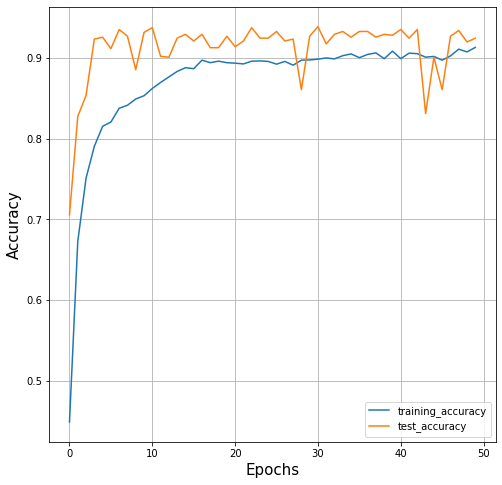

In [319]:
train_mae = history.history['acc']
test_mae = history.history['val_acc']
epochs = range(0,50)
plt.figure(6, figsize=(8,8))
plt.plot(train_mae, label="training_accuracy")
plt.plot(test_mae, label="test_accuracy")
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.grid()

In [320]:
#From above epochs has been been optimized to a value of 15
model.fit( x_train_3D,y_train, epochs = 15 ,batch_size = 50,verbose =2)
LSTM_train = model.predict(x_train_3D, verbose = 2)
LSTM_test = model.predict(x_test_3D, verbose = 2)

Epoch 1/15
 - 0s - loss: 0.0565 - mean_absolute_error: 0.0565 - acc: 0.9089
Epoch 2/15
 - 0s - loss: 0.0565 - mean_absolute_error: 0.0565 - acc: 0.9045
Epoch 3/15
 - 0s - loss: 0.0571 - mean_absolute_error: 0.0571 - acc: 0.9017
Epoch 4/15
 - 0s - loss: 0.0581 - mean_absolute_error: 0.0581 - acc: 0.9027
Epoch 5/15
 - 0s - loss: 0.0554 - mean_absolute_error: 0.0554 - acc: 0.9101
Epoch 6/15
 - 0s - loss: 0.0519 - mean_absolute_error: 0.0519 - acc: 0.9135
Epoch 7/15
 - 0s - loss: 0.0581 - mean_absolute_error: 0.0581 - acc: 0.9042
Epoch 8/15
 - 0s - loss: 0.0558 - mean_absolute_error: 0.0558 - acc: 0.9101
Epoch 9/15
 - 0s - loss: 0.0567 - mean_absolute_error: 0.0567 - acc: 0.9104
Epoch 10/15
 - 0s - loss: 0.0547 - mean_absolute_error: 0.0547 - acc: 0.9073
Epoch 11/15
 - 0s - loss: 0.0535 - mean_absolute_error: 0.0535 - acc: 0.9219
Epoch 12/15
 - 0s - loss: 0.0545 - mean_absolute_error: 0.0545 - acc: 0.9073
Epoch 13/15
 - 0s - loss: 0.0576 - mean_absolute_error: 0.0576 - acc: 0.9014
Epoch 14

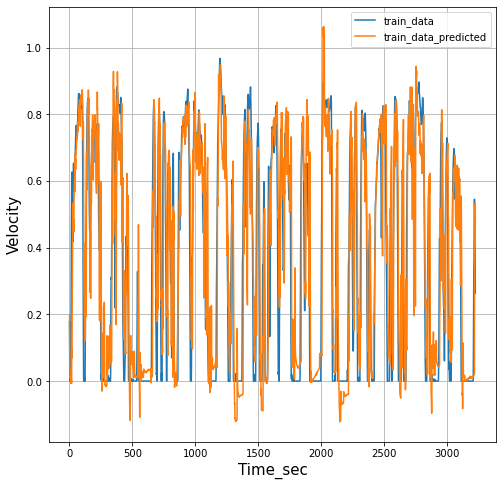

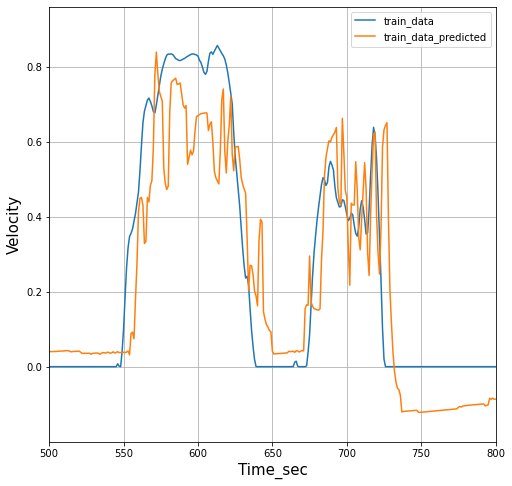

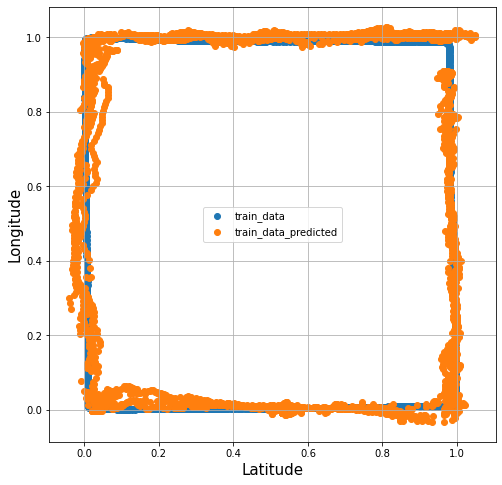

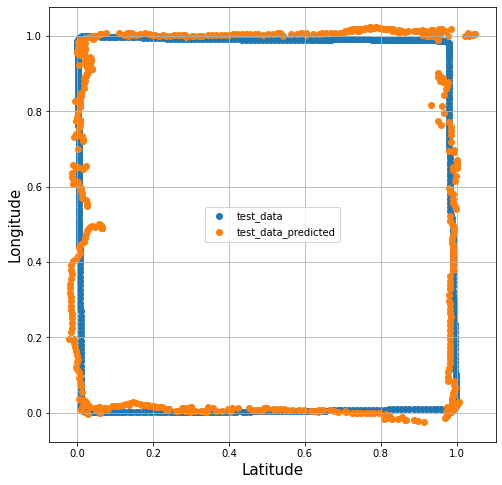

In [321]:
plt.figure(7, figsize=(8,8))
plt.plot(y_train[:,0], label="train_data")
plt.plot(LSTM_train[:,0], label="train_data_predicted" )
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(8, figsize=(8,8))
plt.plot(y_test[:,0], label="train_data")
plt.plot(LSTM_test[:,0], label="train_data_predicted" )
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.xlim(500,800)
plt.legend()
plt.grid()

plt.figure(9, figsize=(8,8))
plt.scatter(y_train[:,1],y_train[:,2], label="train_data")
plt.scatter(LSTM_train[:,1], LSTM_train[:,2] ,label="train_data_predicted")
plt.xlabel('Latitude', fontsize = 15)
plt.ylabel('Longitude', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(10, figsize=(8,8))
plt.scatter(y_test[:,1],y_test[:,2], label="test_data")
plt.scatter(LSTM_test[:,1], LSTM_test[:,2] ,label="test_data_predicted")
plt.xlabel('Latitude', fontsize = 15)
plt.ylabel('Longitude', fontsize = 15)
plt.legend()
plt.grid()